## Funkcje opisujące metodę SUM

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from sympy import *

In [2]:
# Get P_mi, input: ro for i-th system
def get_Pmi(ro, mi):
    ros = ro
    p1 = ((mi*ros)**mi)/(math.factorial(mi)*(1-ros))
    p2 = 0
    for k in range(mi):
        p2 = p2+ ((mi*ros)**k)/math.factorial(k)
    p3 = ((mi*ros)**mi)/(math.factorial(mi)*(1-ros))
    
    return p1*(1/(p2+p3))

In [3]:
# F_ir for type 1,2,4 systems
def get_fir_type_1(ro, roi, K, mi):
    if mi == 1:
        return ro/(1-((K-1)/K)*np.sum(roi))
    if mi > 1:
        return mi*ro + (ro/(1-((K-mi-1)/(K-mi))*roi)) * get_Pmi(roi, mi)

In [4]:
# F_ir for type 3 systems
def get_fir_type_2(lbd, mu):
    return lbd/mu

In [5]:
def fixir(ro, mu, K, mi, e, typ):
    eu = e/mu
    if typ == 1:
        if mi == 1:
            return eu/(1-ro*(K-1)/K)
        if mi > 1:
            return eu + (get_Pmi(ro, mi)*(eu/mi)/(1-((K-mi-1)/(K-mi))*ro))
    else:
        return eu

In [6]:
# Obliczanie macierzy e - średniej liczby wizyty
def get_e(class_num, sys_num, *argv):
    if class_num != len(argv):
        print("Error")
        return; 
    e_mat = np.zeros([class_num, sys_num])
    e = symbols('e:'+str(sys_num))
    i = 0;
    for arg in argv:
        k = np.copy(arg)
        k -= np.eye(sys_num)
        k[0,:] = np.zeros(sys_num)
        k[0,0] = 1
        k = np.c_[k, np.zeros(sys_num)]
        k[0, sys_num] = 1 
        e_mat[i,:] = np.array(list(linsolve(Matrix((k)), e)))
        i += 1
    
    if class_num == 1:
        return e_mat.ravel()
    
    return(e_mat)

In [7]:
def calc_pi(typ, ro, K, sys_num, mi):
    pi = np.zeros([sys_num, K])
    pi0 = np.zeros(sys_num)
    i = 0;
    Q = np.zeros(sys_num)
    for t in typ:
        if t == 2:
            pi0[i] = np.exp(-ro[i])
            for k in range(0, K):
                pi[i,k] = ((ro[i]**k)/(math.factorial(k))) * pi0[i]   
        elif t == 1:
            if mi[i] == 1:
                pi0[i] = 1-ro[i]
                for k in range(0, K):
                    pi[i,k] = pi0[i] * (ro[i]**k)
            else:
                p1 = 0
                for k in range(0,mi[i]):
                    p1 += (mi[i]*ro[i]**k)/math.factorial(k)

                pi0[i] = 1/(p1+ ((mi[i]*ro[i])**mi[i]) * (1/(1-ro[i])))
                #print(pi0[i])
                for k in range(0, K):
                    if k <= (mi[i] - 1):
                        pi[i,k] = pi0[i]*(((mi[i]*ro[i])**k)/(math.factorial(k)))
                    else:
                        pi[i,k] = pi0[i]*(((ro[i]**k) * (mi[i]**mi[i]))/(math.factorial(mi[i])*mi[i]**(k-mi[i])))

            Q[i] = pi0[i]* (ro[i]**(mi[i]+1))/(((mi[i]-ro[i])**2) * math.factorial(mi[i]-1))
        i+=1
    return pi, Q

# PROGRAM DLA 1 KLASY ZGŁOSZEŃ

## Eksperyment 1
Graf przedstawiający badaną sieć zamkniętą z przejściami dla jednej klasy zgłoszeń:
![alt text](img\graf.png "Graf sieci zamkniętej")
Planista jest systemem typu 3, CPU systemem typu 1 z jednym serwerem, natomiast GPU jest systemem z wieloma serwerami, przyjęto k = 2.

In [8]:
# Prawdopodobieństwa przejść 
# !Z [planista, cpu1, cpu2, cpu3, gpu1, gpu2] do  = NAZWA!
planista = [0, 1/3, 1/3, 1/3, 1, 1]
cpu_1 = [1/3, 0, 0, 0, 0, 0]
cpu_2 = [1/3, 0, 0, 0, 0, 0]
cpu_3 = [1/3, 0, 0, 0, 0, 0]
gpu_1 = [0, 1/3, 1/3, 1/3, 0, 0]
gpu_2 = [0, 1/3, 1/3, 1/3, 0, 0]

k1 = np.vstack([planista, cpu_1, cpu_2, cpu_3, gpu_1, gpu_2])
e = get_e(1,6,k1)

#e = [1, 1/3, 1/3, 1/3, 1/3, 1/3]

In [9]:
# Inicjalizacja
K = 6;                   # liczba zgłoszeń w systemie 
K_sum = np.sum(K)

sys_num = 6
mu = np.array([50,100,100,100,80,80])
mi = [float('inf'), 1, 1, 1, 2, 2]
typ = [2, 1, 1, 1, 1, 1]
lbd_d = 0; lbd_g = np.min(mu*mi/e)
err = 0.000001
stop = 0;

In [10]:
# Obliczenia dla każdego systemu i
while stop < 1 :
    Kir = np.zeros(sys_num)
    lbd = (lbd_d+lbd_g)/2
    ro = [lbd*e[k]/(mi[k]*mu[k]) for k in range(len(mu))]
    f = np.zeros(sys_num)
    s = 0;
    for i in range(sys_num):
        if typ[i] == 1:
            Kir[i] = get_fir_type_1(ro[i],ro[i], K, mi[i])
            s = s + Kir[i]
        else:
            Kir[i] = get_fir_type_2(lbd*e[i], mu[i])
            s = s + Kir[i]
    if s > K + err:
        lbd_g = lbd
    elif s < K - err: 
        lbd_d = lbd
    else:
        stop = 1

In [11]:
lbd

133.6902379989624

In [12]:
ro

[0.0,
 0.445634126663208,
 0.445634126663208,
 0.445634126663208,
 0.278521329164505,
 0.278521329164505]

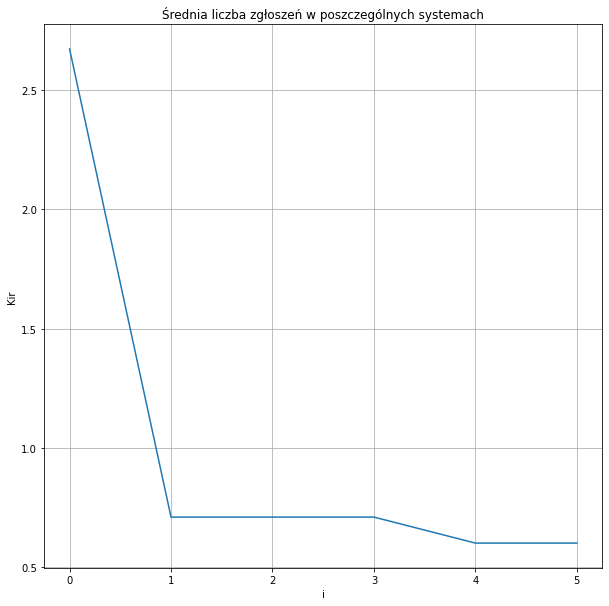

In [13]:
nums = range(6)

plt.figure(figsize=(10,10))
plt.title('Średnia liczba zgłoszeń w poszczególnych systemach')
plt.plot(nums, Kir)
    
plt.xlabel('i')
plt.ylabel('Kir')
plt.grid()
plt.show()

In [14]:
np.sum(Kir)

6.000000090501848

# PROGRAM DLA WIELU KLAS ZGŁOSZEŃ

## Eksperyment 2
  
### Klasa 1  
Klasa 1 zgłoszeń musi zostać przetworzona najpierw przez CPU a następnie GPU.  
![alt text](img\klasa_1.png "Klasa pierwsza")
  
### Klasa 2
Klasa 2 zgłoszeń musi zostać przetworzona najpierw przez GPU a następnie CPU.
![alt text](img\klasa_2.png "Klasa pierwsza")
  
### Klasa 3
Klasa 3 zgłoszeń musi zostać przetworzona tylko przez CPU.
![alt text](img\klasa_3.png "Klasa pierwsza")
  
### Klasa 4
Klasa 4 zgłoszeń musi zostać przetworzona tylko przez GPU.
![alt text](img\klasa_4.png "Klasa pierwsza")

### Określanie prawdopodobieństw przejść

In [26]:
# Określenie prawdopodobieństw przejść dla każdej klasy
#           [p_11, p_21, ..., p_n1]
#           [p_12, p_22, ..., p_n2]
# klasa_i = [p_13, p_23, ..., p_n3]
#           [        ...          ]
#           [p_1n, p_2n, ..., p_nn]

K1 = np.array([[0, 0, 0, 0, 1, 1],
               [1/3, 0, 0, 0, 0, 0],
               [1/3, 0, 0, 0, 0, 0],
               [1/3, 0, 0, 0, 0, 0],
               [0, 0.5, 0.5, 0.5, 0, 0],
               [0, 0.5, 0.5, 0.5, 0, 0]])

K2 = np.array([[0, 1, 1, 1, 0, 0],
               [0, 0, 0, 0, 1/3, 1/3],
               [0, 0, 0, 0, 1/3, 1/3],
               [0, 0, 0, 0, 1/3, 1/3],
               [1/2, 0, 0, 0, 0, 0],
               [1/2, 0, 0, 0, 0, 0]])

K3 = np.array([[0, 1, 1, 1, 0, 0],
               [1/3, 0, 0, 0, 0, 0],
               [1/3, 0, 0, 0, 0, 0],
               [1/3, 0, 0, 0, 0, 0],
               [0, 0, 0, 0, 0, 0],
               [0, 0, 0, 0, 0, 0]])

K4 = np.array([[0, 0, 0, 0, 1, 1],
               [0, 0, 0, 0, 0, 0],
               [0, 0, 0, 0, 0, 0],
               [0, 0, 0, 0, 0, 0],
               [1/2, 0, 0, 0, 0, 0],
               [1/2, 0, 0, 0, 0, 0]])
clas_num = 4
sys_num = 6

e = get_e(clas_num,sys_num, K1, K2, K3, K4)
print(e)

[[1.    0.333 0.333 0.333 0.5   0.5  ]
 [1.    0.333 0.333 0.333 0.5   0.5  ]
 [1.    0.333 0.333 0.333 0.    0.   ]
 [1.    0.    0.    0.    0.5   0.5  ]]


### Inicjalizacja 

In [16]:
# Inicjalizacja
K = [2, 1, 3, 3];                   # liczba zgłoszeń w systemie 
K_sum = np.sum(K)

clas_num = 4
sys_num = 6

mu = np.array([[120,80,80,80,50,50],
             [120,70,70,70,60,60],
             [120,50,50,50,80,80],
             [120,100,100,100,30,30]])

mi = [float('inf'), 1, 1, 1, 2, 2]
typ = [2, 1, 1, 1, 1, 1]

In [27]:
lbd = np.ones(clas_num)*0.00001
err = 0.001

In [28]:
stop = 0
step = 0;
lbd_old = np.copy(lbd)

while stop < 1:
    step = step + 1
    ro = np.zeros(sys_num)
    roi = np.zeros([clas_num, sys_num])
    for i in range(sys_num):
        temp = np.zeros(clas_num)
        for k in range(clas_num):  
            if typ[i] == 1:
                temp[k] = lbd[k]*e[k,i]/(mi[i]*mu[k,i])
            else:
                temp[k] = lbd[k]*e[k,i]/(mu[k,i])
        roi[:,i] = np.copy(temp)
        ro[i] = np.sum(temp)
    #print(roi)
    r = 0; i = 0;
    for r in range(clas_num):
        s = 0
        for i in range(sys_num):            
            s = s + fixir(ro[i], mu[r,i], K_sum, mi[i], e[r,i], typ[i])
            
        lbd[r] = K[r]/s   
   
    s = 0
    for i in range(clas_num):
        s = s + (lbd_old[i]-lbd[i])**2
    
    if np.sqrt(s) < err:
        stop = 1
        ro = np.zeros(sys_num)
        roi = np.zeros([clas_num, sys_num])
        for i in range(sys_num):
            temp = np.zeros(clas_num)
            for k in range(clas_num):  
                if typ[i] == 1:
                    temp[k] = lbd[k]*e[k,i]/(mi[i]*mu[k,i])
                else:
                    temp[k] = lbd[k]*e[k,i]/(mu[k,i])
            roi[:,i] = np.copy(temp)
            ro[i] = np.sum(temp)
        
    lbd_old = np.copy(lbd) 
    #print(np.sqrt(s))

In [29]:
Kir = np.zeros([sys_num,clas_num])
s = 0
for r in range(clas_num):
    for i in range(sys_num):
        if typ[i] == 1:
            Kir[i,r] = get_fir_type_1(roi[r,i],ro[i], K_sum, mi[i])
            s = s + Kir[i,r]
        else:
            Kir[i,r] = get_fir_type_2(lbd[r]*e[r,i], mu[r,i])
            s = s + Kir[i,r]


In [20]:
# Warunek ergodyczności

for i in range(len(mi)):
    if mi[i] == float('inf'):
        print('System', i, ' is stable')
    else:
        if np.all(mu[:,i]*mi[i] - lbd*e[:,i] > 0):
            print('System', i, ' is stable')
        else:
            print('System', i, ' is unstable')

System 0  is stable
System 1  is stable
System 2  is stable
System 3  is stable
System 4  is stable
System 5  is stable


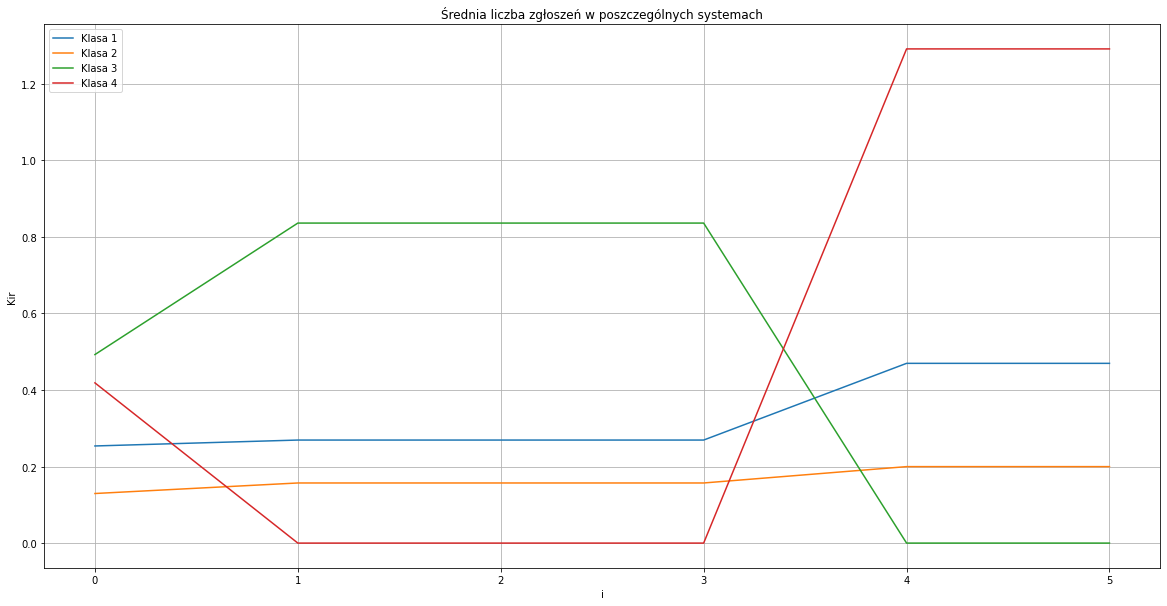

In [21]:
nums = range(6)

plt.figure(figsize=(20,10))
plt.title('Średnia liczba zgłoszeń w poszczególnych systemach')
plt.plot(nums, Kir)
leg = []
for i in range(clas_num):
    leg.append('Klasa '+str(i+1))
    
plt.legend(leg)
plt.xlabel('i')
plt.ylabel('Kir')
plt.grid()
plt.show()

In [22]:
# Lambda ir
lbd_ir = np.zeros([clas_num, sys_num]);
for i in range(sys_num):
    lbd_ir[:,i] = lbd*e[:,i]
print('Lambda ir: ')

np.set_printoptions(precision=3)
print(lbd_ir)

Lambda ir: 
[[30.442 10.147 10.147 10.147 15.221 15.221]
 [15.541  5.18   5.18   5.18   7.77   7.77 ]
 [59.092 19.697 19.697 19.697  0.     0.   ]
 [50.217  0.     0.     0.    25.109 25.109]]


In [30]:
lbd

array([30.442, 15.541, 59.092, 50.217])

In [31]:
pi,Q =  calc_pi(typ, ro, K_sum+1, sys_num, mi)
print('Średnia długość kolejki: ')
for i in range(len(Q)):
    print('    System ', i, ': ', Q[i])

Średnia długość kolejki: 
    System  0 :  0.0
    System  1 :  0.873053271834679
    System  2 :  0.873053271834679
    System  3 :  0.873053271834679
    System  4 :  0.01789268868488875
    System  5 :  0.01789268868488875


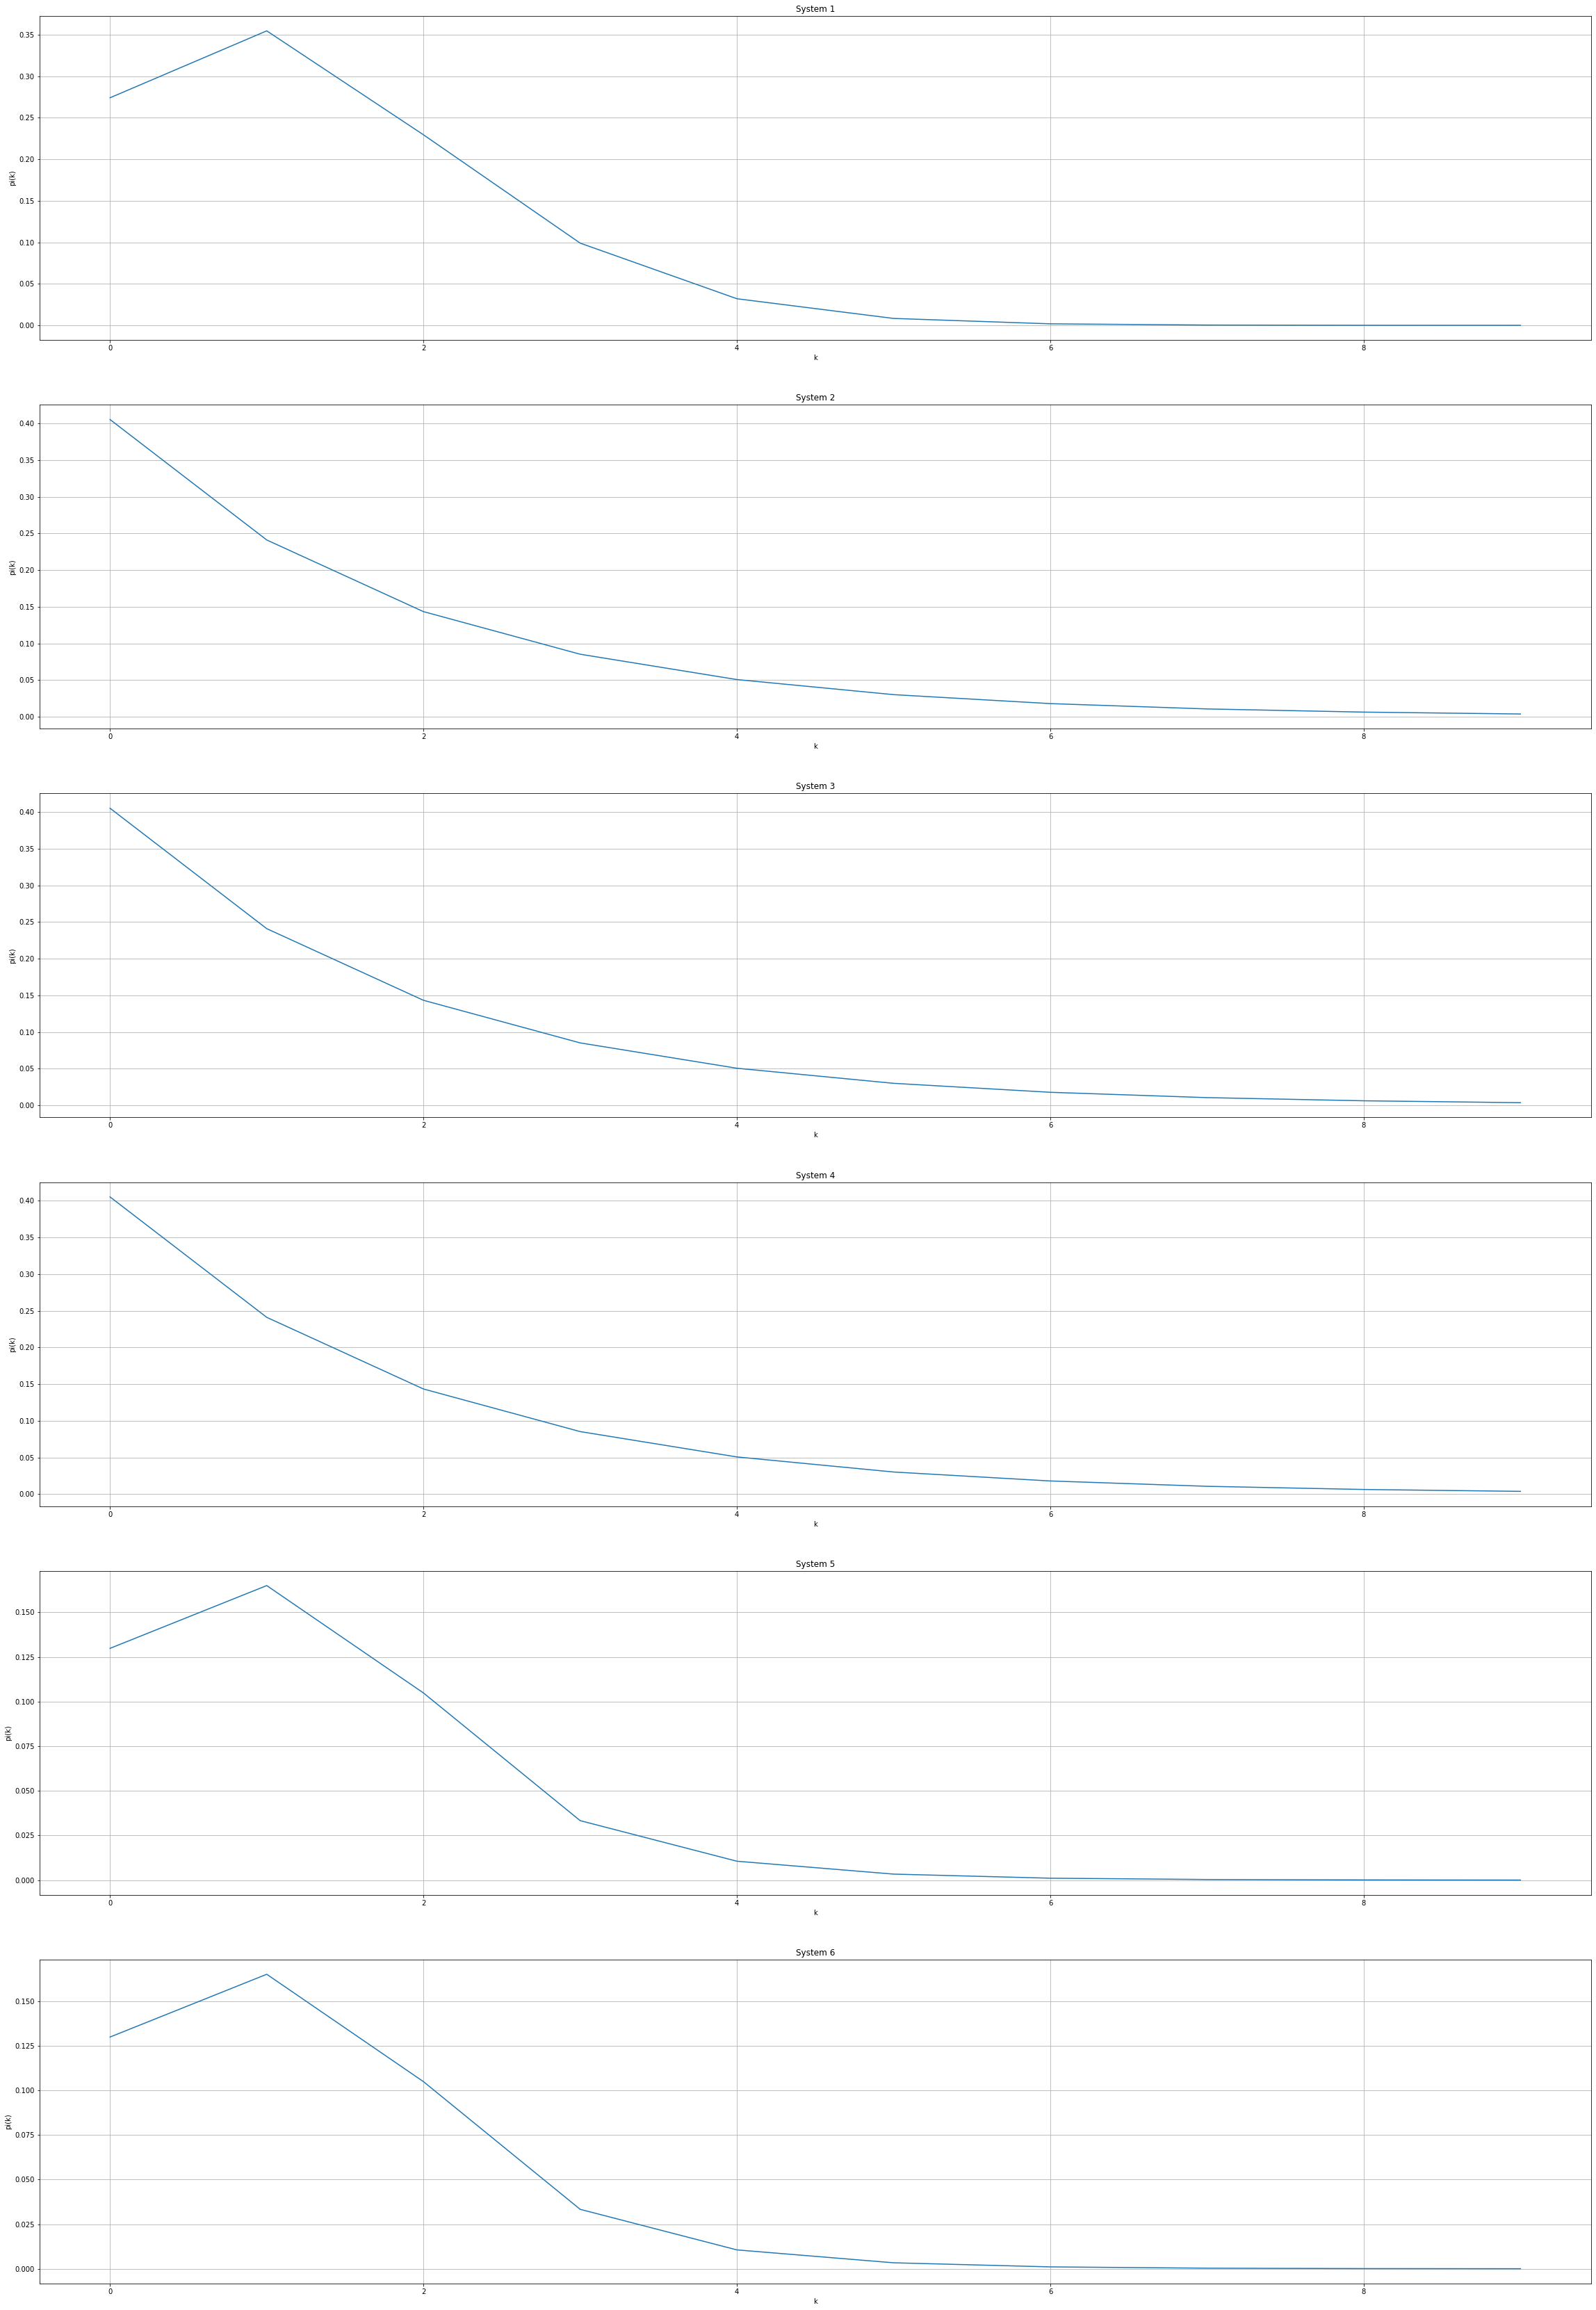

In [32]:
fig, axs = plt.subplots(sys_num, 1, figsize = [40, sys_num*10])
for i in range(len(mi)):
    axs[i].plot(pi[i])
    axs[i].grid()
    axs[i].set_title('System {}'.format(i + 1))
    axs[i].set_xlabel('k')
    axs[i].set_ylabel('pi(k)')

In [33]:
T = Kir/lbd_ir.T
print('Średni czas odpowiedzi: ')
print(T)

Średni czas odpowiedzi: 
[[0.008 0.008 0.008 0.008]
 [0.027 0.03  0.042   nan]
 [0.027 0.03  0.042   nan]
 [0.027 0.03  0.042   nan]
 [0.031 0.026   nan 0.051]
 [0.031 0.026   nan 0.051]]


<ipython-input-33-e78e652121b1>:1: RuntimeWarning: invalid value encountered in true_divide
  T = Kir/lbd_ir.T
